## Import Libraries

In [2]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid,save_image
import torchvision.utils as vutils
from torchvision.datasets.utils import download_and_extract_archive

from matplotlib import pyplot as plt
import matplotlib.animation as animation

from typing import Callable, Optional
from IPython.display import HTML

from tqdm import tqdm
import numpy as np

## Check GPU Availability

In [3]:
!nvidia-smi

Sat Aug 17 19:02:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   42C    P0    34W / 250W |    877MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [4]:
device_num = 1

if torch.cuda.is_available():
    torch.cuda.set_device(device_num)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    device_num = -1
print(f"Using device - {device}: {device_num}")

Using device - cuda: 1


## Load DataSets

In [5]:
class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://drive.usercontent.google.com/download?id=1SlCFLq3GtDQ-LXKWNGxrvNsCkALIREgl&confirm=t&uuid=77e34988-8be5-4489-9807-6c286402cd06"

    def __init__(self, root: str, desired_class: Optional[str] = None, force_download: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        super().__init__(root=root, transform=transform, target_transform=target_transform)

        if desired_class is not None:
            self.samples = [s for s in self.samples if self.classes[s[1]] in desired_class]
            self.targets = [s[1] for s in self.samples]
            print(f"INFO: Filtered dataset to include classes: {desired_class}")

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not os.path.isfile(os.path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [6]:
img_size = 128
img_norm = dict(
    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
)

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(**img_norm),
    transforms.RandomHorizontalFlip(p=0.5),
])

In [7]:
data_root = os.path.join(".", "data")
target_class = "Bread"
dataset = FoodImageDataset(root=data_root, desired_class=target_class, force_download=False, transform=transform)

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Filtered dataset to include classes: Bread


## DataLoader

In [8]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

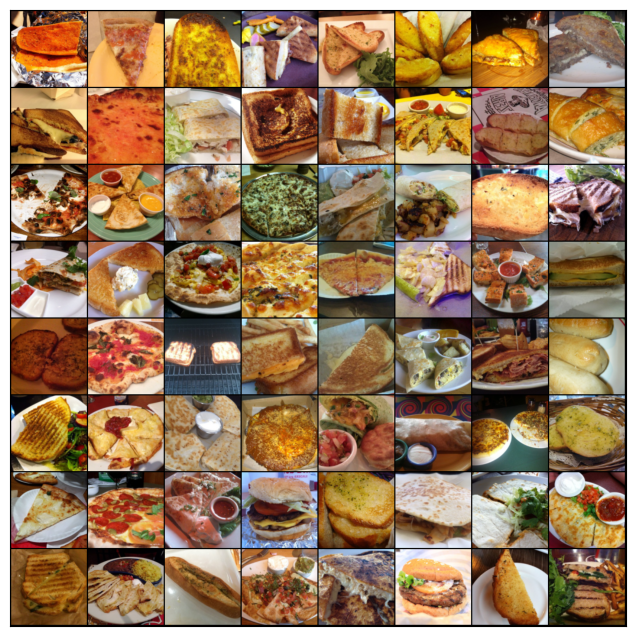

In [9]:
def denorm(img_tensors):
    return img_tensors * img_norm["mean"][0] + img_norm["std"][0]


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
  
def show_batch(dataloader, nmax=64):
    for img, _ in dataloader:
        show_images(img, nmax)
        break
        
show_batch(dataloader)

## GAN Model Structure

In [10]:
latent_size = 128

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

## Train

In [15]:
netG = Generator().to(device)
netD = Discriminator().to(device)

torch.Size([64, 3, 128, 128])


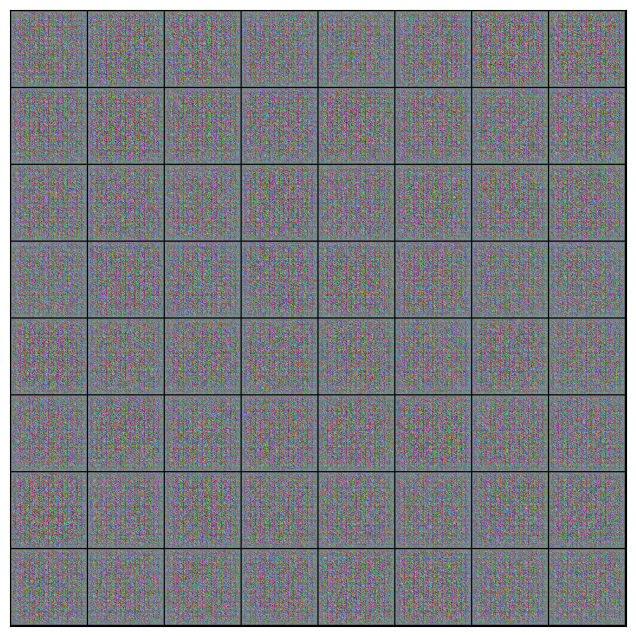

In [16]:
noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake = netG(noise)
print(fake.shape)
show_images(fake.cpu())

In [17]:
fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

lr = 0.0002

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [18]:
import os
result_dir = "result"
os.makedirs(result_dir, exist_ok=True)

In [19]:
num_epochs = 500

G_losses = []
D_losses = []

for epoch in range(num_epochs):
    # tqdm을 사용하여 진행 상황을 업데이트
    pbar = tqdm(enumerate(dataloader, 0), total=len(dataloader), desc=f"Epoch [{epoch+1:3}/{num_epochs}]")

    for i, data in pbar:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        # 실제 이미지로부터의 손실 계산
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 가짜 이미지 생성 및 손실 계산
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # 실제 이미지와 가짜 이미지를 이용한 최종 손실 계산 및 Discriminator 업데이트
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator를 위한 가짜 라벨은 진짜로 설정
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # tqdm 진행 상태 업데이트
        pbar.set_postfix({
            'Loss_D': f'{errD.item():.4f}',
            'Loss_G': f'{errG.item():.4f}',
            'D(x)': f'{D_x:.4f}',
            'D(G(z))': f'{D_G_z1:.4f}/{D_G_z2:.4f}'
        })

    # 손실 값 기록 (에포크 단위로)
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # 10 에포크마다 Generator의 결과를 저장
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_grid = vutils.make_grid(fake, padding=2, normalize=True)
        img_filename = f"epoch_{epoch+1:03}.png"
        img_path = os.path.join(result_dir, img_filename)
        vutils.save_image(img_grid, img_path)

Epoch [  1/500]:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch [500/500]: 100%|██████████| 22/22 [00:13<00:00,  1.61it/s, Loss_D=0.0068, Loss_G=9.1072, D(x)=0.9937, D(G(z))=0.0003/0.0004] 


## Result

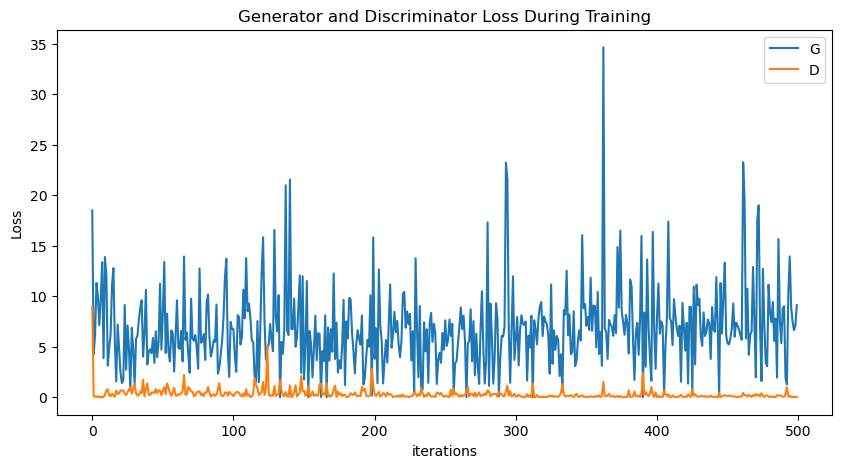

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization of G’s progression

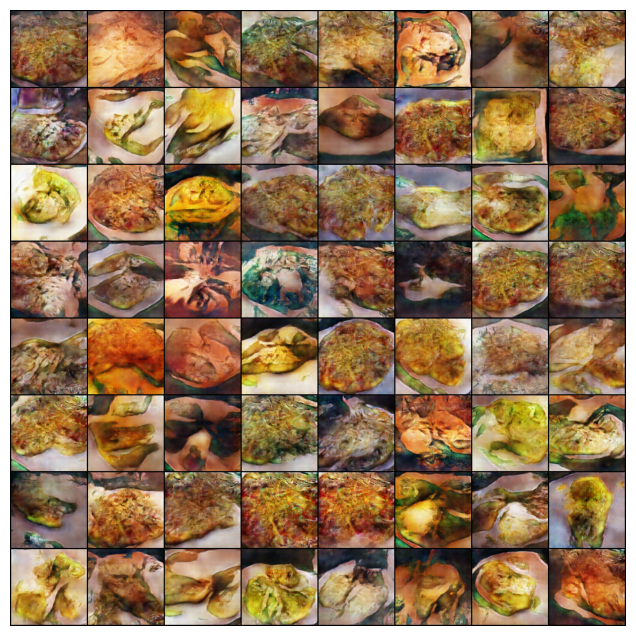

In [27]:
rand_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)


# Generator를 통해 이미지 생성
with torch.no_grad():  # 그래디언트 계산을 비활성화하여 더 빠르게 처리
    generated_images = netG(rand_noise).detach().cpu()

# 생성된 이미지들을 그리드로 만들기
grid = vutils.make_grid(generated_images, nrow=8, normalize=True)

# 그리드 이미지를 시각화하기 위해 차원 변환
# 이미지의 차원 변환: (C, H, W) -> (H, W, C)
grid_image = np.transpose(grid, (1, 2, 0))

# 생성된 64개의 이미지 시각화
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(grid_image)
plt.show()

## Model Save